In [1]:
import pandas as pd
import sys
import numpy as np
import sys
import sklearn as sk
import matplotlib.pyplot as plt
sys.path.append('/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana')
from sbnd.constants import *
from sbnd.prism import *
from sbnd.cafclasses.pfp import PFP
from sbnd.cafclasses.nu import NU
from sbnd.cafclasses.mcprim import MCPRIM
from sbnd.cafclasses import object_calc
from sbnd.general import utils
from sbnd.general import plotters
from sbnd.plotlibrary import makeplot
from pyanalib import panda_helpers

day = plotters.day

%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = '/sbnd/data/users/brindenc/analyze_sbnd/nue/v09_72_01'
fnames = ['caf_nue_samegen.df','caf_nue_samegen_cheat.df','caf_nue_samegen_cheat_vtx.df']
names = ['nocheat','cheat','cheat_vtx']

In [3]:
pfp_nocheat = PFP(pd.read_hdf(f'{DATA_DIR}/{fnames[0]}',key='pfp'))
pfp_nocheat.postprocess()
pfp_nocheat.stats()

nu_nocheat = NU(pd.read_hdf(f'{DATA_DIR}/{fnames[0]}',key='mcnu'))
nu_nocheat.postprocess()

prim_nocheat = MCPRIM(pd.read_hdf(f'{DATA_DIR}/{fnames[0]}',key='mcprim'))
prim_nocheat = prim_nocheat.postprocess()

nocheat_toteng = pfp_nocheat.get_total_reco_energy()
nocheat_mintheta = pfp_nocheat.get_min_theta()
nocheat_electron = pfp_nocheat.get_true_parts_from_pdg(pdg=11,remove_nan=False)

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: PerformanceWarning: indexing past lexsort depth may impact performance.
  if await self.run_code(code, result, async_=asy):
/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana/sbnd/cafclasses/pfp.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.
  true_ntrk,true_nshw = count_true_tracks_showers(particles.pdg.loc[ind])
/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana/sbnd/cafclasses/pfp.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [4]:
pfp_cheat = PFP(pd.read_hdf(f'{DATA_DIR}/{fnames[1]}',key='pfp'))
pfp_cheat.postprocess(is_cheat=True)
pfp_cheat.stats()

nu_cheat = NU(pd.read_hdf(f'{DATA_DIR}/{fnames[1]}',key='mcnu'))
nu_cheat.postprocess()

prim_cheat = MCPRIM(pd.read_hdf(f'{DATA_DIR}/{fnames[1]}',key='mcprim'))
prim_cheat = prim_cheat.postprocess()

cheat_toteng = pfp_cheat.get_total_reco_energy()
cheat_mintheta = pfp_cheat.get_min_theta()
cheat_electron = pfp_cheat.get_true_parts_from_pdg(pdg=11,remove_nan=False)

In [5]:
pfp_vtx = PFP(pd.read_hdf(f'{DATA_DIR}/{fnames[2]}',key='pfp'))
pfp_vtx.postprocess()
pfp_vtx.stats()

nu_vtx = NU(pd.read_hdf(f'{DATA_DIR}/{fnames[2]}',key='mcnu'))
nu_vtx.postprocess()

prim_vtx = MCPRIM(pd.read_hdf(f'{DATA_DIR}/{fnames[2]}',key='mcprim'))
prim_vtx = prim_vtx.postprocess()

vtx_toteng = pfp_vtx.get_total_reco_energy()
vtx_mintheta = pfp_vtx.get_min_theta()
vtx_electron = pfp_vtx.get_true_parts_from_pdg(pdg=11,remove_nan=False)

In [6]:
#Get pfps shared among files
pfps = [pfp_nocheat,pfp_cheat,pfp_vtx]
indices = [list(pfp.index.drop_duplicates()) for pfp in pfps]
shared_indices = utils.common_indices(*indices)
shared_pfps = [PFP(pfp.loc[shared_indices]) for pfp in pfps]

#get shared other objects
shared_totengs = [nocheat_toteng.loc[shared_indices],cheat_toteng.loc[shared_indices],vtx_toteng.loc[shared_indices]]
shared_minthetas = [nocheat_mintheta.loc[shared_indices],cheat_mintheta.loc[shared_indices],vtx_mintheta.loc[shared_indices]]
shared_electrons = [nocheat_electron.loc[shared_indices],cheat_electron.loc[shared_indices],vtx_electron.loc[shared_indices]]

#Even lower level objects
shared_nshw = [pfp[pfp.true_nshw == 1].nshw.groupby(level=[0,1,2]).first() for pfp in shared_pfps]
shared_ntrk = [pfp[pfp.true_nshw == 1].ntrk.groupby(level=[0,1,2]).first() for pfp in shared_pfps]
shared_true_nshw = [pfp[pfp.true_nshw == 1].true_nshw.groupby(level=[0,1,2]).first() for pfp in shared_pfps]
shared_true_ntrk = [pfp[pfp.true_nshw == 1].true_ntrk.groupby(level=[0,1,2]).first() for pfp in shared_pfps]
    

In [7]:
def split_series_nreco(pfp,mcprim):
  """
  Split a pfp into multiple based on nreco
  """
  no_reco_index = utils.find_indices_not_in_common(
    pfp.index.drop_duplicates(),mcprim.index.drop_duplicates()
  )
  
  #nreco indices
  ntrk0_indices = pfp.index[pfp.ntrk == 0].drop_duplicates()
  ntrk1_indices = pfp.index[pfp.ntrk == 1].drop_duplicates()
  ntrk2_indices = pfp.index[pfp.ntrk >= 2].drop_duplicates()

  nshw0_indices = pfp.index[pfp.nshw == 0].drop_duplicates()
  nshw1_indices = pfp.index[pfp.nshw == 1].drop_duplicates()
  nshw2_indices = pfp.index[pfp.nshw >= 2].drop_duplicates()


  ntrk0_nshw0_indices = no_reco_index
  ntrk0_nshw1_indices = utils.find_indices_in_common(ntrk0_indices,nshw1_indices)
  ntrk0_nshw2_indices = utils.find_indices_in_common(ntrk0_indices,nshw2_indices)
  ntrk1_nshw0_indices = utils.find_indices_in_common(ntrk1_indices,nshw0_indices)
  ntrk1_nshw1_indices = utils.find_indices_in_common(ntrk1_indices,nshw1_indices)
  ntrk1_nshw2_indices = utils.find_indices_in_common(ntrk1_indices,nshw2_indices)
  ntrk2_nshw0_indices = utils.find_indices_in_common(ntrk2_indices,nshw0_indices)
  ntrk2_nshw1_indices = utils.find_indices_in_common(ntrk2_indices,nshw1_indices)
  ntrk2_nshw2_indices = utils.find_indices_in_common(ntrk2_indices,nshw2_indices)
  
  indices = [
      ntrk0_nshw1_indices,
      ntrk0_nshw2_indices,
      ntrk1_nshw0_indices,
      ntrk1_nshw1_indices,
      ntrk1_nshw2_indices,
      ntrk2_nshw0_indices,
      ntrk2_nshw1_indices,
      ntrk2_nshw2_indices,
  ]
  print(
    #ntrk0_nshw1_indices,
    #pfp.index[pfp.ntrk == 0].drop_duplicates(),
    #pfp.index[pfp.nshw == 1].drop_duplicates(),
      len(ntrk0_nshw1_indices),
      len(ntrk0_nshw2_indices),
      len(ntrk1_nshw0_indices),
      len(ntrk1_nshw1_indices),
      len(ntrk1_nshw2_indices),
      len(ntrk2_nshw0_indices),
      len(ntrk2_nshw1_indices),
      len(ntrk2_nshw2_indices)
  )
  return [pfp.loc[index] for index in indices],indices,no_reco_index
  
  

In [8]:
#Get pfps as function of reconstructed events
pfp_nocheat_nrecos,nocheat_nreco_indices,nocheat_noreco_indices = split_series_nreco(pfp_nocheat,prim_nocheat[prim_nocheat.in_tpc.values])
pfp_cheat_nrecos,cheat_nreco_indices,cheat_noreco_indices = split_series_nreco(pfp_cheat,prim_cheat[prim_cheat.in_tpc.values])
pfp_vtx_nrecos,vtx_nreco_indices,vtx_noreco_indices = split_series_nreco(pfp_vtx,prim_vtx[prim_vtx.in_tpc.values])

#Store in some lists
pfps_nrecos = [pfp_nocheat_nrecos,pfp_cheat_nrecos,pfp_vtx_nrecos]
nrecos_indices = [nocheat_nreco_indices,cheat_nreco_indices,vtx_nreco_indices]
norecos_indices = [nocheat_noreco_indices,cheat_noreco_indices,vtx_noreco_indices]

#get shared indices
nocheat_nreco_indices_shared = [utils.find_indices_in_common(ind,shared_indices) for ind in nocheat_nreco_indices]
cheat_nreco_indices_shared = [utils.find_indices_in_common(ind,shared_indices) for ind in cheat_nreco_indices]
vtx_nreco_indices_shared = [utils.find_indices_in_common(ind,shared_indices) for ind in vtx_nreco_indices]

nreco_labels = [
    r'$n_{trk}$ = 0 $n_{shw}$ = 0',
    r'$n_{trk}$ = 0 $n_{shw}$ = 1',
    r'$n_{trk}$ = 0 $n_{shw}$ $\geq$ 2',
    r'$n_{trk}$ = 1 $n_{shw}$ = 0',
    r'$n_{trk}$ = 1 $n_{shw}$ = 1',
    r'$n_{trk}$ = 1 $n_{shw}$ $\geq$ 2',
    r'$n_{trk}$ $\geq$ 2 $n_{shw}$ = 0',
    r'$n_{trk}$ $\geq$ 2 $n_{shw}$ = 1',
    r'$n_{trk}$ $\geq$ 2 $n_{shw}$ $\geq$ 2',
  ]

327 54 60 92 34 9 12 8
654 0 0 0 0 0 0 0
524 33 97 48 10 2 1 0


In [9]:
def plot_files_series(series,xlabels,labels,bins,savenames,ylabel=None,title=None,save=False,
                      **pltkwargs):
  for x,xlabel,bi,savename in zip(series,xlabels,bins,savenames):
    #Make plot
    fig,ax = makeplot.plot_hist(x,labels=labels,xlabel=xlabel,bins=bi,**pltkwargs)
    if ylabel is not None:
      ax.set_ylabel(ylabel)
    plotters.set_style(ax,legend_size=10,
                       #legend_loc=(1.05,0.5)
                       )
    print(savename)
    if save:
      plotters.save_plot(f'{savename}')
      plt.close('all')
  return fig,ax
  

In [13]:
pfp_cheat.shw.truth.bestmatch

G4ID    energy energy_completeness energy_purity  \
                                                                         
run subrun evt                                                           
1   49     1   -2147483648       NaN                 NaN           NaN   
           1             2  0.820120                 1.0           1.0   
           2   -2147483648       NaN                 NaN           NaN   
           2             2  0.026507                 1.0           1.0   
           3   -2147483648       NaN                 NaN           NaN   
...                    ...       ...                 ...           ...   
    48     8             2  0.012664                 1.0           1.0   
           9   -2147483648       NaN                 NaN           NaN   
           9             2  0.328377                 1.0           1.0   
           10  -2147483648       NaN                 NaN           NaN   
           10            2  0.098768                 1.0           1.0   

               hit_completeness hit_purity  
                                            
run subrun evt                              
1   49     1                NaN        NaN  
           1                1.0        1.0  
           2                NaN        NaN  
           2                1.0        1.0  
           3                NaN        NaN  
...                         ...        ...  
    48     8                1.0        1.0  
           9                NaN        NaN  
           9                1.0        1.0  
           10               NaN        NaN  
           10               1.0        1.0  

[1308 rows x 6 columns]

In [14]:
eng_err = [object_calc.get_err(reco,true) for reco,true in zip(shared_totengs,[e.genE for e in shared_electrons])]
theta_diff = [object_calc.get_err(reco,true,normalize=False) for reco,true in zip(shared_minthetas,[e.theta for e in shared_electrons])]

series = [
  # eng_err,
  # theta_diff,
  # eng_err,
  # theta_diff,
  #[shared_totengs[0].loc[ind] for ind in nocheat_nreco_indices],
  # [pfp.shw.stat.dif.vtx.dropna() for pfp in shared_pfps],
  # [pfp.shw.stat.dif.start.x.dropna() for pfp in shared_pfps],
  # [pfp.shw.stat.dif.start.y.dropna() for pfp in shared_pfps],
  # [pfp.shw.stat.dif.start.z.dropna() for pfp in shared_pfps],
  # [pfp.shw.stat.dif.vtx.dropna() for pfp in shared_pfps],
  # [pfp.shw.stat.dif.start.x.dropna() for pfp in shared_pfps],
  # [pfp.shw.stat.dif.start.y.dropna() for pfp in shared_pfps],
  # [pfp.shw.stat.dif.start.z.dropna() for pfp in shared_pfps],
  #[pfp.shw.razzle.electronScore.dropna() for pfp in shared_pfps],
  [pfp.shw.stat.dif.vtx.dropna() for pfp in pfp_vtx_nrecos],
]
xlabels = [
  # r'Reco - True / True ($E$)',
  # r'Reco - True ($\theta$)',
  # r'Reco - True / True ($E$)',
  # r'Reco - True ($\theta$)',
  #r'$E_{reco}$',
  # r'Reco - True (Vtx)',
  # r'Reco - True (x Vtx)',
  # r'Reco - True (y Vtx)',
  # r'Reco - True (z Vtx)',
  # r'Reco - True (Vtx)',
  # r'Reco - True (x Vtx)',
  # r'Reco - True (y Vtx)',
  # r'Reco - True (z Vtx)',
  #r'Razzle Electron Score',
  r'Reco - True (Vtx)',
]
bins = [
  # 20,
  # 20,
  # np.arange(-0.2,0.1,0.02),
  # np.arange(-0.1,0.5,0.03),
  #20,
  # 20,
  # 20,
  # 20,
  # 20,
  # np.arange(0,50,2.5),
  # np.arange(-5,5,0.5),
  # np.arange(-5,5,0.5),
  # np.arange(0,50,2.5),
  #20,
  #np.arange(0,20,2),
  np.arange(0,0.5,0.05),
]
savenames = [
  # 'shw_eng_err',
  # 'shw_theta_diff',
  # 'shw_eng_err_zoom',
  # 'shw_theta_diff_zoom',
  #'shw_eng_nocheat',
  # 'vtx_diff',
  # 'vtxx_diff',
  # 'vtxu_diff',
  # 'vtxz_diff',
  # 'vtx_diff_zoom',
  # 'vtxx_diff_zoom',
  # 'vtxu_diff_zoom',
  # 'vtxz_diff_zoom',
  #'razzle_e_score',
  'cheatvtx_vtx_diff_dens_zoom',
]


[[0.267004, 0.004874, 0.329415, 1.0], [0.275191, 0.194905, 0.496005, 1.0], [0.212395, 0.359683, 0.55171, 1.0], [0.153364, 0.497, 0.557724, 1.0], [0.122312, 0.633153, 0.530398, 1.0], [0.288921, 0.758394, 0.428426, 1.0], [0.626579, 0.854645, 0.223353, 1.0], [0.993248, 0.906157, 0.143936, 1.0]]


ValueError: RGBA sequence should have length 3 or 4

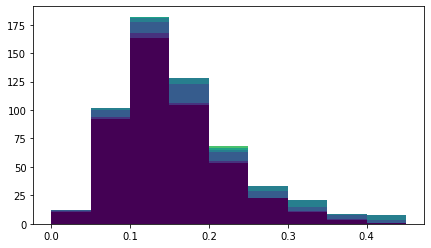

In [15]:
plot_files_series(series,xlabels,nreco_labels[1:],bins,savenames,
                  lw=2,
                  histtype='barstacked',
                  draw_edge=True,
                  #density=True,
                  #ylabel='Density',
                  #save=True
                  )

shw_theta_nocheat_dens
shw_theta_cheat_dens
shw_theta_vtx_dens


/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


(<Figure size 504x288 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta_{reco}$', ylabel='Density'>)

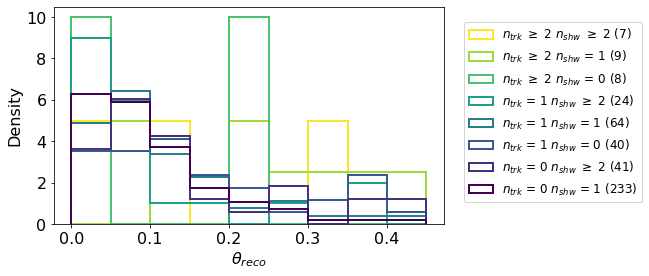

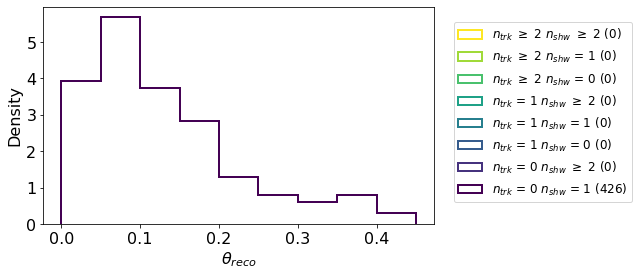

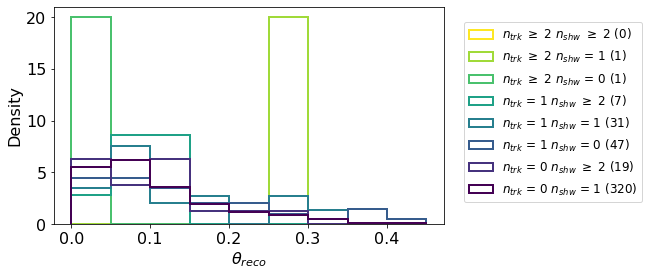

In [219]:
series = [
  #[shared_totengs[0].loc[ind] for ind in nocheat_nreco_indices_shared],
  #[shared_totengs[1].loc[ind] for ind in cheat_nreco_indices_shared],
  #[shared_totengs[2].loc[ind] for ind in vtx_nreco_indices_shared],
  # [shared_minthetas[0].loc[ind] for ind in nocheat_nreco_indices_shared],
  # [shared_minthetas[1].loc[ind] for ind in cheat_nreco_indices_shared],
  # [shared_minthetas[2].loc[ind] for ind in vtx_nreco_indices_shared],
]
xlabels = [
  #r'$E_{reco}$',
  #r'$E_{reco}$',
  #r'$E_{reco}$',
  # r'$\theta_{reco}$',
  # r'$\theta_{reco}$',
  # r'$\theta_{reco}$',
]
bins = [
  #np.arange(0,2,0.2),
  #np.arange(0,2,0.2),
  #np.arange(0,2,0.2),
  # np.arange(0,0.5,0.05),
  # np.arange(0,0.5,0.05),
  # np.arange(0,0.5,0.05),
  
]
savenames = [
  #'shw_eng_nocheat',
  #'shw_eng_cheat',
  #'shw_eng_vtx',
  'shw_theta_nocheat_dens',
  'shw_theta_cheat_dens',
  'shw_theta_vtx_dens',
]

plot_files_series(series,xlabels,nreco_labels[1:],bins,savenames,
                  ylabel='Density',
                  lw=2,histtype='step',
                  density=True,
                  #save=True
                  )

In [14]:
def plot_files_hist2d(pfps,xkeys,xlabels,ykeys,ylabels,savenames,bins,save=False,
               **pltkwargs):
  for xkey,xlabel,ykey,ylabel,savename,bi in zip(xkeys,xlabels,ykeys,ylabels,savenames,bins):
    for i,pfp in enumerate(pfps):
      xcol = panda_helpers.getcolumns([xkey],depth=pfps[0].key_length())[0]
      ycol = panda_helpers.getcolumns([ykey],depth=pfps[0].key_length())[0]
      
      xseries = pfp.loc[:,xcol].dropna(inplace=False)
      yseries = pfp.loc[:,ycol].dropna(inplace=False)
      
      #Make plot
      fig,ax = makeplot.plot_hist2d(xseries,yseries,xlabel,ylabel,title=names[i],bins=bi,
                                    **pltkwargs)
      ax.set_ylabel(ylabel)
      ax.set_xlabel(xlabel)
      plotters.set_style(ax)
      #Save
      print(xkey.replace(".","_"))
      if save:
        plotters.save_plot(f'hist2d_{ykey.replace(".","_")}{xkey.replace(".","_")}{savename}')
        plt.close('all')
  return fig,ax

def plot_files_hist2d_series(xseries,xlabels,yseries,ylabels,savenames,bins,titles,save=False,
               **pltkwargs):
  for i,(x,xlabel,y,ylabel,savename,bi,title) in enumerate(zip(xseries,xlabels,yseries,ylabels,savenames,bins,titles)):
    #Make plot
    fig,ax = makeplot.plot_hist2d(x,y,xlabel,ylabel,title=title,bins=bi,
                                  **pltkwargs)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plotters.set_style(ax)
    #Save
    print(savename)
    if save:
      plotters.save_plot(f'{savename}')
      plt.close('all')
  return fig,ax

In [52]:
shared_vtxx = [[None,None]]*len(shared_pfps)
shared_vtxy = [[None,None]]*len(shared_pfps)
shared_vtxz = [[None,None]]*len(shared_pfps)

for i in range(len(shared_pfps)):
  shared_vtxx[i][0],shared_vtxx[i][1] = object_calc.get_nonna(shared_pfps[i].shw.start.x,shared_pfps[i].shw.truth.p.start.x)
  shared_vtxy[i][0],shared_vtxy[i][1] = object_calc.get_nonna(shared_pfps[i].shw.start.y,shared_pfps[i].shw.truth.p.start.y)
  shared_vtxz[i][0],shared_vtxz[i][1] = object_calc.get_nonna(shared_pfps[i].shw.start.z,shared_pfps[i].shw.truth.p.start.z)
  

xs = [
  # shared_totengs[2],
  # shared_totengs[1],
  # shared_totengs[0],
  # shared_totengs[2],
  # shared_totengs[1],
  # shared_totengs[0],
  # shared_nshw[0],
  # shared_ntrk[0],
  # shared_nshw[1],
  # shared_ntrk[1],
  # shared_nshw[2],
  # shared_ntrk[2],
  # shared_minthetas[2],
  # shared_minthetas[1],
  # shared_minthetas[0],
  # shared_minthetas[2],
  # shared_minthetas[1],
  # shared_minthetas[0],
  shared_vtxx[2][0],
  shared_vtxy[2][0],
  shared_vtxz[2][0],
  shared_vtxx[1][0],
  shared_vtxy[1][0],
  shared_vtxz[1][0],
  shared_vtxx[0][0],
  shared_vtxy[0][0],
  shared_vtxz[0][0],
  
  
]
ys = [
  # shared_electrons[1].genE.dropna(inplace=False),
  # shared_electrons[1].genE.dropna(inplace=False),
  # shared_electrons[0].genE.dropna(inplace=False),
  # shared_electrons[1].genE.dropna(inplace=False),
  # shared_electrons[1].genE.dropna(inplace=False),
  # shared_electrons[0].genE.dropna(inplace=False),
  # shared_true_nshw[0],
  # shared_true_ntrk[0],
  # shared_true_nshw[1],
  # shared_true_ntrk[1],
  # shared_true_nshw[2],
  # shared_true_ntrk[2],
  # shared_electrons[2].theta.fillna(0),
  # shared_electrons[1].theta.fillna(0),
  # shared_electrons[0].theta.fillna(0),
  # shared_electrons[2].theta.fillna(0),
  # shared_electrons[1].theta.fillna(0),
  # shared_electrons[0].theta.fillna(0),
  shared_vtxx[2][1],
  shared_vtxy[2][1],
  shared_vtxz[2][1],
  shared_vtxx[1][1],
  shared_vtxy[1][1],
  shared_vtxz[1][1],
  shared_vtxx[0][1],
  shared_vtxy[0][1],
  shared_vtxz[0][1],
  
]
xlabels = [
  # r'$E_{reco}$',
  # r'$E_{reco}$',
  # r'$E_{reco}$',
  # r'$E_{reco}$',
  # r'$E_{reco}$',
  # r'$E_{reco}$',
  # r'Reco $n_{shw}$',
  # r'Reco $n_{trk}$',
  # r'Reco $n_{shw}$',
  # r'Reco $n_{trk}$',
  # r'Reco $n_{shw}$',
  # r'Reco $n_{trk}$',
  # r'$\theta_{reco}$',
  # r'$\theta_{reco}$',
  # r'$\theta_{reco}$',
  # r'$\theta_{reco}$',
  # r'$\theta_{reco}$',
  # r'$\theta_{reco}$',
  'Reco vtx (x)',
  'Reco vtx (y)',
  'Reco vtx (z)',
  'Reco vtx (x)',
  'Reco vtx (y)',
  'Reco vtx (z)',
  'Reco vtx (x)',
  'Reco vtx (y)',
  'Reco vtx (z)',
]
ylabels = [
  # r'$E_{true}$',
  # r'$E_{true}$',
  # r'$E_{true}$',
  # r'$E_{true}$',
  # r'$E_{true}$',
  # r'$E_{true}$',
  # r'True $n_{shw}$',
  # r'True $n_{trk}$',
  # r'True $n_{shw}$',
  # r'True $n_{trk}$',
  # r'True $n_{shw}$',
  # r'True $n_{trk}$',
  # r'$\theta_{true}$',
  # r'$\theta_{true}$',
  # r'$\theta_{true}$',
  # r'$\theta_{true}$',
  # r'$\theta_{true}$',
  # r'$\theta_{true}$',
  'True vtx (x)',
  'True vtx (y)',
  'True vtx (z)',
  'True vtx (x)',
  'True vtx (y)',
  'True vtx (z)',
  'True vtx (x)',
  'True vtx (y)',
  'True vtx (z)',
]
savenames = [
  # f'hist2d_eng_{names[2]}',
  # f'hist2d_eng_{names[1]}',
  # f'hist2d_eng_{names[0]}',
  # f'hist2d_eng_{names[2]}_zoom',
  # f'hist2d_eng_{names[1]}_zoom',
  # f'hist2d_eng_{names[0]}_zoom',
  # f'confusion_nshw_{names[0]}',
  # f'confusion_ntrk_{names[0]}',
  # f'confusion_nshw_{names[1]}',
  # f'confusion_ntrk_{names[1]}',
  # f'confusion_nshw_{names[2]}',
  # f'confusion_ntrk_{names[2]}',
  # f'hist2d_theta_{names[2]}',
  # f'hist2d_theta_{names[1]}',
  # f'hist2d_theta_{names[0]}',
  # f'hist2d_theta_{names[2]}_zoom',
  # f'hist2d_theta_{names[1]}_zoom',
  # f'hist2d_theta_{names[0]}_zoom',
  f'hist2d_vtxx_{names[2]}',
  f'hist2d_vtxy_{names[2]}',
  f'hist2d_vtxz_{names[2]}',
  f'hist2d_vtxx_{names[1]}',
  f'hist2d_vtxy_{names[1]}',
  f'hist2d_vtxz_{names[1]}',
  f'hist2d_vtxx_{names[0]}',
  f'hist2d_vtxy_{names[0]}',
  f'hist2d_vtxz_{names[0]}',
]
bins = [
  # 30,
  # 30,
  # 30,
  # np.arange(0,1,0.05),
  # np.arange(0,1,0.05),
  # np.arange(0,1,0.05),
  # np.arange(0,7,1),
  # np.arange(0,7,1),
  # np.arange(0,7,1),
  # np.arange(0,7,1),
  # np.arange(0,7,1),
  # np.arange(0,7,1),
  # np.arange(0,0.5,0.025),
  # np.arange(0,0.5,0.025),
  # np.arange(0,0.5,0.025),
  # np.arange(0,0.2,0.01),
  # np.arange(0,0.2,0.01),
  # np.arange(0,0.2,0.01),
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
]
titles = [
  # names[2],
  # names[1],
  # names[0],
  # names[2],
  # names[1],
  # names[0],
  # names[0],
  # names[0],
  # names[1],
  # names[1],
  # names[2],
  # names[2],
  # names[2],
  # names[1],
  # names[0],
  # names[2],
  # names[1],
  # names[0],
  # names[2],
  # names[1],
  # names[0],
  # names[2],
  # names[1],
  # names[0],
  names[2],
  names[2],
  names[2],
  names[1],
  names[1],
  names[1],
  names[0],
  names[0],
  names[0],
]

plot_files_hist2d_series(xs,xlabels,ys,ylabels,savenames,bins,titles,label_boxes=False,
                         plot_line=True,
                         save=True)
#print(len(xs[0]),len(ys[0]))


hist2d_vtxx_cheat_vtx
hist2d_vtxy_cheat_vtx
hist2d_vtxz_cheat_vtx
hist2d_vtxx_cheat
hist2d_vtxy_cheat
hist2d_vtxz_cheat
hist2d_vtxx_nocheat
hist2d_vtxy_nocheat
hist2d_vtxz_nocheat


(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'nocheat'}, xlabel='Reco vtx (z)', ylabel='True vtx (z)'>)

In [17]:
shared_vtxx[2][0] == shared_vtxx[1][0]

run  subrun  evt
1    49      1      True
             3      True
             4      True
             6      True
             8      True
                    ... 
     48      5      True
             6      True
             7      True
             9      True
             10     True
Name: x, Length: 490, dtype: bool

In [251]:
x,y = object_calc.get_nonna(shared_pfps[0].shw.start.x,shared_pfps[0].shw.truth.p.start.x)
x
#~(shared_pfps[0].shw.start.x.isna() & shared_pfps[0].shw.truth.p.start.x.isna())

run  subrun  evt
1    49      1     -100.161705
             3      173.465683
             4       33.193634
             4       33.252884
             6       51.762840
                       ...    
     48      7     -134.262314
             9     -138.785355
             10      13.250229
             10      11.924952
             10      12.599118
Name: x, Length: 648, dtype: float32

run  subrun  evt
1    49      1      0.303954
             3      0.529964
             4      0.024246
             4      0.024246
             6      0.144675
                      ...   
     48      7      0.275719
             9      0.118289
             10     0.061407
             10     0.061407
             10     0.061407
Name: (shw, truth, p, genE, ), Length: 695, dtype: float32
shw_bestplane_energy
run  subrun  evt
1    49      1      0.303954
             3      0.529964
             4      0.024246
             6      0.144675
             8      0.158560
                      ...   
     48      5      0.717569
             6      0.718387
             7      0.275719
             9      0.118289
             10     0.061407
Name: (shw, truth, p, genE, ), Length: 426, dtype: float32
shw_bestplane_energy
run  subrun  evt
1    49      1      0.303954
             3      0.529964
             4      0.024246
             6      0.144675
             8      0.158560
      

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'cheat_vtx'}, xlabel='$E_{reco}$', ylabel='$E_{true}$'>)

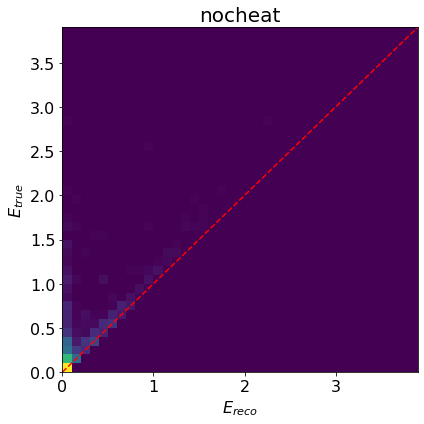

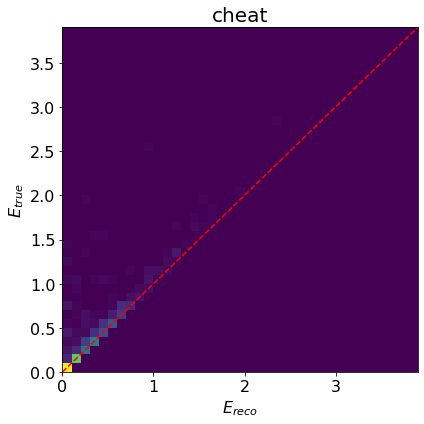

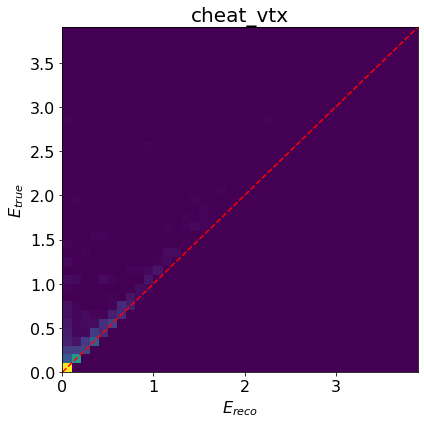

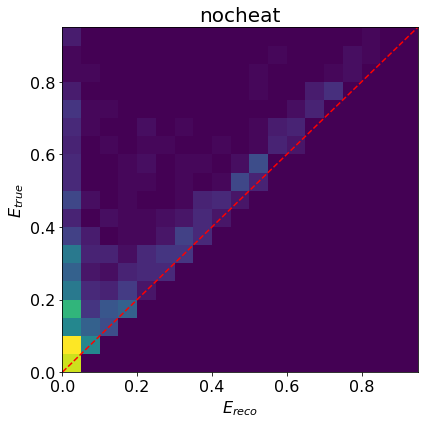

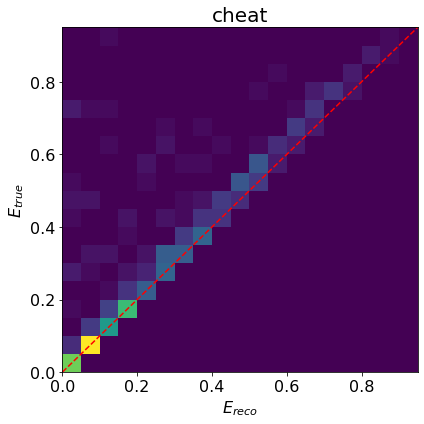

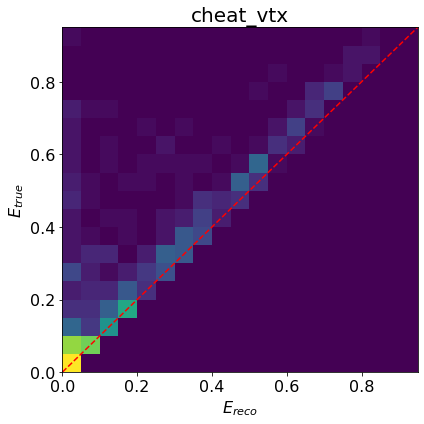

In [147]:
xkeys = [
  'shw.bestplane_energy',
  'shw.bestplane_energy',
]
xlabels = [
  r'$E_{reco}$',
  r'$E_{reco}$',
]
ykeys = [
  'shw.truth.p.genE',
  'shw.truth.p.genE',
]
ylabels = [
  r'$E_{true}$',
  r'$E_{true}$',
]
savenames = [
  '',
  '_zoom',
]
bins = [
  np.arange(0,4,0.1),
  np.arange(0,1,0.05),
]

plot_files_hist2d(shared_pfps,xkeys,xlabels,ykeys,ylabels,savenames,bins=bins,plot_line=True)

In [151]:
#pfp_nocheat.loc[pfp_nocheat.index.drop_duplicates()[3]].shw.truth
object_calc.get_row_vals(pfp_nocheat.shw.bestplane_energy,pfp_nocheat.index.drop_duplicates())

(1, 5, 1)      0.025556
(1, 5, 2)      0.264761
(1, 5, 3)      0.417997
(1, 5, 4)      0.968566
(1, 5, 5)      0.333727
                 ...   
(1, 99, 6)     0.139112
(1, 99, 7)     0.733666
(1, 99, 8)     0.325739
(1, 99, 9)     0.647574
(1, 99, 10)    0.624907
Name: bestplane_energy, Length: 596, dtype: float32

In [ ]:
def plot_files(pfps,keys,xlabels,labels,bins,savenames,ylabel=None,save=False,
               **pltkwargs):
  for key,xlabel,bi,savename in zip(keys,xlabels,bins,savenames):
    col = panda_helpers.getcolumns([key],depth=pfps[0].key_length())[0]
    series = [pfp.loc[:,col].dropna(inplace=False) for pfp in pfps]
    
    #Make plot
    fig,ax = makeplot.plot_hist(series,labels=labels,xlabel=xlabel,bins=bi,**pltkwargs)
    if ylabel is not None:
      ax.set_ylabel(ylabel)
    plotters.set_style(ax,legend_size=13)
    #,legend_loc='upper left'
    #Save
    print(key.replace(".","_"))
    if save:
      plotters.save_plot(f'{key.replace(".","_")}{savename}')
      plt.close('all')
  return fig,ax
    

In [ ]:
# keys = [
#   #'shw.stat.mae.vtx',
#   #'shw.stat.dif.vtx',
#   #'shw.stat.dif.start.x',
#   #'shw.stat.dif.start.y',
#   #'shw.stat.dif.start.z',
#   #'shw.stat.mae.energy',
#   # 'shw.stat.dif.theta',
#   # 'shw.stat.mae.theta',
#   # 'shw.stat.dif.theta',
  
#   ]
# xlabels = [
#   'Reco - True / True (Vtx)',
#   'Reco - True (Vtx)',
#   'Reco - True (x-Vtx)',
#   'Reco - True (y-Vtx)',
#   'Reco - True (z-Vtx)',
#   r'Reco - True / True ($E$)',
#   r'Reco - True ($\theta$)',
#   r'Reco - True / True ($\theta$)',
#   r'Reco - True ($\theta$)',
  
# ]
# bins = [
#   np.arange(0,0.5,0.02),
#   20,
#   20,
#   20,
#   20,
#   20,
#   20,
#   20,
#   np.arange(-0.1,1,0.05),
# ]

# savenames = [
#   '',
#   '',
#   '',
#   '',
#   '',
#   '',
#   '',
#   '',
#   '_zoom',
  
# ]

# fig,ax = plot_files(shared_pfps,keys,xlabels,names,bins,savenames,
#            ylabel='Density',
#            save=False,
#            cmap='plasma',lw=2,histtype='step',density=True)

shw_stat_dif_theta
shw_stat_mae_theta
shw_stat_dif_theta


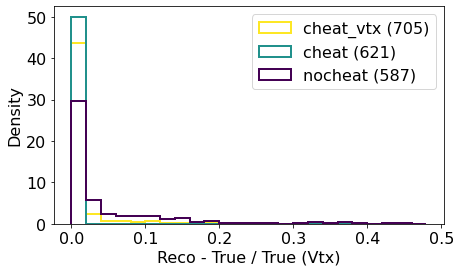

In [22]:
#Set data
series = [pfp.shw.stat.mae.vtx.dropna(inplace=False) for pfp in pfps]
xlabel = 'Reco - True / True (Vtx)'

#Make plot
fig,ax = makeplot.plot_hist(series,labels=names,xlabel=xlabel,
                            histtype='step',lw=2,bins=np.arange(0,0.5,0.02),density=True)
ax.set_ylabel('Density')
plotters.set_style(ax)
plotters.save_plot('vtxerr_file_comp')

In [ ]:
xlabel = 'Reco - True / True (Vtx)'
for pfp_nrecos,name,nreco_indices,noreco_indices in zip(pfps_nrecos,names)
series = [pfp.shw.stat.mae.vtx.dropna(inplace=False) for pfp in pfp_nocheat_nrecos]
title = f'nocheat ({len(list(utils.flatten_list(nocheat_nreco_indices)+nocheat_noreco_indices))})'

fig,ax = makeplot.plot_hist(series,labels=nreco_labels[1:],xlabel=xlabel,
                            title=title,
                            histtype='step',lw=2,bins=np.arange(0,0.5,0.05)
                            )
ax.set_ylabel('Counts')
plotters.set_style(ax,legend_size=12)
plotters.save_plot('nocheat_vtx_mae')

fig,ax = makeplot.plot_hist(series,labels=nreco_labels[1:],xlabel=xlabel,
                            title=title,
                            histtype='step',lw=2,bins=np.arange(0,0.5,0.05),density=True
                            )
ax.set_ylabel('Density')
plotters.set_style(ax,legend_size=12)
plotters.save_plot('nocheat_vtx_mae_dens')

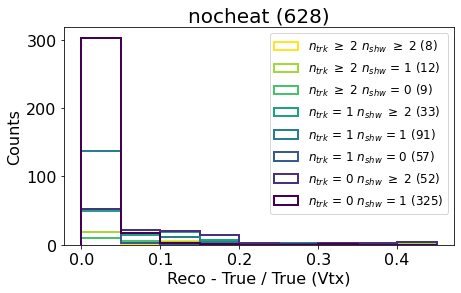

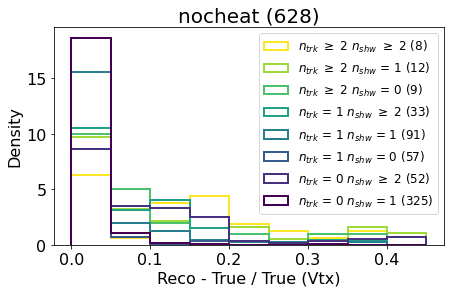

In [23]:
series = [pfp.shw.stat.mae.vtx.dropna(inplace=False) for pfp in pfp_nocheat_nrecos]
xlabel = 'Reco - True / True (Vtx)'
title = f'nocheat ({len(list(utils.flatten_list(nocheat_nreco_indices)+nocheat_noreco_indices))})'

fig,ax = makeplot.plot_hist(series,labels=nreco_labels[1:],xlabel=xlabel,
                            title=title,
                            histtype='step',lw=2,bins=np.arange(0,0.5,0.05)
                            )
ax.set_ylabel('Counts')
plotters.set_style(ax,legend_size=12)
plotters.save_plot('nocheat_vtx_mae')

fig,ax = makeplot.plot_hist(series,labels=nreco_labels[1:],xlabel=xlabel,
                            title=title,
                            histtype='step',lw=2,bins=np.arange(0,0.5,0.05),density=True
                            )
ax.set_ylabel('Density')
plotters.set_style(ax,legend_size=12)
plotters.save_plot('nocheat_vtx_mae_dens')

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


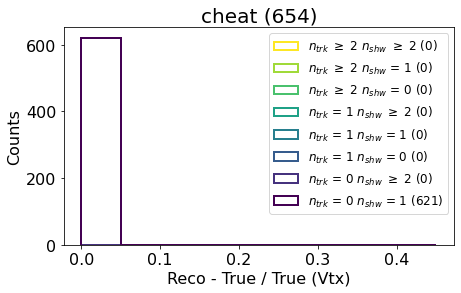

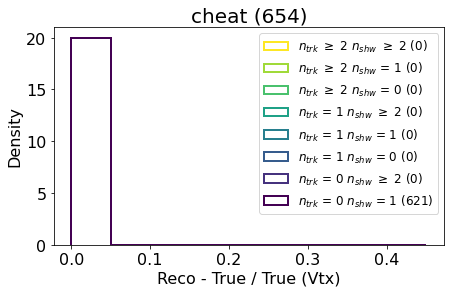

In [24]:
fig,ax = makeplot.plot_hist([pfp.shw.stat.mae.vtx.dropna(inplace=False) for pfp in pfp_cheat_nrecos],labels=nreco_labels[1:],xlabel='Reco - True / True (Vtx)',
                            title=f'cheat ({len(list(utils.flatten_list(cheat_nreco_indices)+cheat_noreco_indices))})',
                            histtype='step',lw=2,bins=np.arange(0,0.5,0.05)
                            )
ax.set_ylabel('Counts')
plotters.set_style(ax,legend_size=12)
plotters.save_plot('cheat_vtx_mae')

fig,ax = makeplot.plot_hist([pfp.shw.stat.mae.vtx.dropna(inplace=False) for pfp in pfp_cheat_nrecos],labels=nreco_labels[1:],xlabel='Reco - True / True (Vtx)',
                            title=f'cheat ({len(list(utils.flatten_list(cheat_nreco_indices)+cheat_noreco_indices))})',
                            histtype='step',lw=2,bins=np.arange(0,0.5,0.05),density=True
                            )
ax.set_ylabel('Density')
plotters.set_style(ax,legend_size=12)
plotters.save_plot('cheat_vtx_mae_dens')

In [ ]:
len(nocheat_nreco_indices[0])+len(nocheat_noreco_indices)

359

In [ ]:
np.unique(pfp_cheat.shw.stat.mae.vtx)

array([0.        , 0.00432767,        nan], dtype=float32)

In [ ]:
pfp.postprocess()

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: PerformanceWarning: indexing past lexsort depth may impact performance.
  if await self.run_code(code, result, async_=asy):
/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana/sbnd/cafclasses/pfp.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[:,cols[0]][cont] = np.sqrt(self.trk.rangeP.p_muon**2+mu**2)
/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana/sbnd/cafclasses/pfp.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [ ]:
pfp.add_stat(object_calc.get_err,'mae',normalize=True)
#Reco - True
pfp.add_stat(object_calc.get_err,'diff',normalize=False)

/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana/sbnd/cafclasses/object_calc.py:43: RuntimeWarning: invalid value encountered in subtract
  err = np.linalg.norm(reco-true,axis=1)
/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: invalid value encountered in multiply
  s = (x.conj() * x).real


In [ ]:
#pfp.shw.stat.mae.theta
#pfp.shw.theta


run  subrun  evt
1    27      1             NaN
             1             NaN
             1        9.953870
             2             NaN
             2      408.845209
                       ...    
     48      9       67.355323
             10            NaN
             10       0.093735
             10       1.458048
             10     127.577080
Name: Etheta2, Length: 1554, dtype: float64

In [ ]:
pfp.add_stat(sk.metrics.r2_score,'r2')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
pfp.shw.stat

mae                                                     \
                   Etheta2    energy     start                          theta   
                                             x         y         z              
run subrun evt                                                                  
1   27     1           NaN       NaN       NaN       NaN       NaN        NaN   
           1           NaN -0.956825       NaN       NaN       NaN        NaN   
           1      9.953870 -0.055317  0.001489 -0.024747  0.037202   2.405185   
           2           NaN       NaN       NaN       NaN       NaN        NaN   
           2    408.845209 -0.331949 -0.000501 -0.001331  0.000022  23.768816   
...                    ...       ...       ...       ...       ...        ...   
    48     9     67.355323 -0.048641 -0.000245 -0.000532  0.002786   7.476448   
           10          NaN       NaN       NaN       NaN       NaN        NaN   
           10     0.093735 -0.885934 -0.082325 -0.025045  2.506598  -4.096555   
           10     1.458048 -0.843202 -0.174110 -0.130445  4.291777   2.959356   
           10   127.577080 -0.459542 -0.127419 -0.098921  3.875804 -16.424134   

                          
                     vtx  
                          
run subrun evt            
1   27     1         NaN  
           1         NaN  
           1    0.034361  
           2         NaN  
           2    0.000344  
...                  ...  
    48     9    0.002395  
           10        NaN  
           10   0.210335  
           10   0.377101  
           10   0.330941  

[1554 rows x 7 columns]

['Etheta2', 'energy', 'startx', 'starty', 'startz', 'theta', 'vtx']

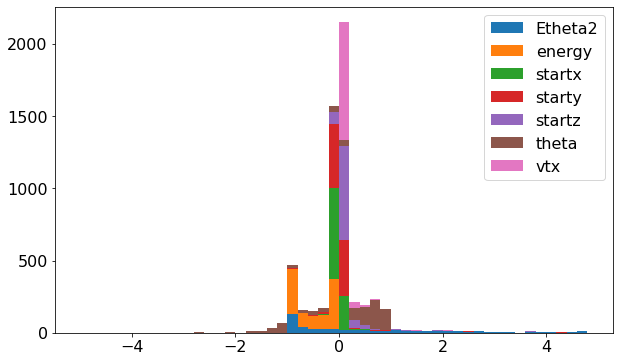

In [ ]:
import matplotlib.pyplot as plt
labels = [''.join(key) for key in pfp.shw.err.keys()]

fig,ax = plt.subplots(figsize=(10,6))
ax.hist(pfp.shw.err ,histtype='barstacked',label=labels,bins=np.arange(-5,5,0.2))
ax.legend()
plotters.set_style(ax)
labels


In [ ]:
ind = (1,49,1)
#pfp_cheat.shw.truth.p.loc[ind].theta,pfp_cheat.shw.dir.loc[ind],pfp_cheat.shw.theta.loc[ind]
pfp_cheat.loc[ind].to_csv('test.csv')
p = np.array([0.0027,-0.0127,0.3037])
di = np.array([0.028,-0.037,0.9989])

p/np.linalg.norm(p)
#nu_dir = np.array([-0.0024,0.006])

/tmp/ipykernel_7083/488907926.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  pfp_cheat.loc[ind].to_csv('test.csv')


array([ 0.00888224, -0.04177942,  0.99908738])

In [ ]:
pfp.trk.err

Etheta2    energy     start                         theta  \
                                           x         y         z             
                                                                             
run subrun evt                                                               
1   27     1         NaN       NaN       NaN       NaN       NaN       NaN   
           1         NaN       NaN       NaN       NaN       NaN       NaN   
           1    0.044575  0.210811 -0.156357 -0.618881 -0.154785  0.079373   
           2         NaN       NaN       NaN       NaN       NaN       NaN   
           2    0.151662  0.116834 -0.218567  0.041313  0.009613  0.944185   
...                  ...       ...       ...       ...       ...       ...   
    48     9    0.224510  0.107905  0.058838  0.113358  0.017914  0.882031   
           10        NaN       NaN       NaN       NaN       NaN       NaN   
           10   0.003991  0.057366 -1.192980 -0.377895  3.838246 -0.249334   
           10   0.007131  0.065363 -2.535603 -1.126090  6.810600  0.180068   
           10   0.128605  0.084355 -1.839789 -1.300454  6.079085 -1.000998   

                     vtx  
                          
                          
run subrun evt            
1   27     1         NaN  
           1         NaN  
           1    0.656826  
           2         NaN  
           2    0.222645  
...                  ...  
    48     9    0.128968  
           10        NaN  
           10   4.037096  
           10   7.354021  
           10   6.483154  

[1554 rows x 7 columns]

In [ ]:
mu = 0.105
(pfp.trk.rangeP.p_muon**2+mu**2),pfp.trk.truth.p.genE**2
pfp.trk.keys()

MultiIndex([( 'producer',            '',               '',  ''),
            (    'start',           'x',               '',  ''),
            (    'start',           'y',               '',  ''),
            (    'start',           'z',               '',  ''),
            (      'end',           'x',               '',  ''),
            (      'end',           'y',               '',  ''),
            (      'end',           'z',               '',  ''),
            (      'dir',           'x',               '',  ''),
            (      'dir',           'y',               '',  ''),
            (      'dir',           'z',               '',  ''),
            (      'len',            '',               '',  ''),
            (   'rangeP',      'p_muon',               '',  ''),
            (     'mcsP',   'fwdP_muon',               '',  ''),
            (   'rangeP',      'p_pion',               '',  ''),
            (     'mcsP',   'fwdP_pion',               '',  ''),
            ('bestplane',

In [ ]:
shared_totengs[0].shape,shared_electrons[0].genE.dropna(inplace=False),len(set(shared_electrons[0].index))
{x for x in shared_electrons[0].index if list(shared_electrons[0].index).count(x) > 1}
shared_electrons[0].loc[(1,15,3)].pdg == 11

/tmp/ipykernel_7083/3525161266.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  shared_electrons[0].loc[(1,15,3)].pdg == 11


run  subrun  evt
1    15      3      False
             3       True
Name: pdg, dtype: bool

In [ ]:
from sbnd import volume

volume.involume(pfp.trk.start),pfp.trk.start

(run  subrun  evt
 1    27      1      False
              1      False
              1       True
              2      False
              2       True
                     ...  
      48      9      False
              10     False
              10      True
              10      True
              10      True
 Length: 1554, dtype: bool,
                          x           y           z
                                                   
                                                   
 run subrun evt                                    
 1   27     1           NaN         NaN         NaN
            1           NaN         NaN         NaN
            1     84.181137 -158.683014  333.145905
            2           NaN         NaN         NaN
            2    167.899597   98.552872  410.300690
 ...                    ...         ...         ...
     48     9   -138.760483  200.098495  401.598999
            10          NaN         NaN         NaN
            10    13.245928   12.

In [ ]:
pfp_nochange = PFP(pfp.copy())
type(pfp_nochange)

sbnd.cafclasses.pfp.PFP

In [ ]:
pfp.shw.bestplane_energy

run  subrun  evt
1    27      1     -5.000000
             1      0.012639
             1      0.263946
             2     -5.000000
             2      0.026699
                      ...   
     48      9      0.112535
             10    -5.000000
             10     0.007004
             10     0.009629
             10     0.033188
Name: bestplane_energy, Length: 1554, dtype: float32

In [ ]:
pfp_nochange.shw.bestplane_energy

run  subrun  evt
1    27      1     -5.000000
             1      0.012639
             1      0.263946
             2     -5.000000
             2      0.026699
                      ...   
     48      9      0.112535
             10    -5.000000
             10     0.007004
             10     0.009629
             10     0.033188
Name: bestplane_energy, Length: 1554, dtype: float32

In [ ]:
pfp.clean()
pfp.shw_energy_fix()

In [ ]:
pfp.shw.bestplane_energy == pfp_nochange.shw.bestplane_energy

run  subrun  evt
1    27      1      False
             1       True
             1      False
             2      False
             2       True
                    ...  
     48      9       True
             10     False
             10      True
             10      True
             10      True
Name: bestplane_energy, Length: 1554, dtype: bool

In [ ]:
pfp

parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -5.000000     -1  2 NaN  4294967295   
           1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.471059      1  0 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3  -5.000000     -1  3 NaN  4294967295   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...         shw  \
                     start                          ...       truth   
                         x           y           z  ...           p   
                                                    ...         end   
                                                    ...           y   
run subrun evt                                      ...               
1   27     1           NaN         NaN         NaN  ...         NaN   
           1           NaN         NaN         NaN  ... -153.135117   
           1     84.181137 -158.683014  333.145905  ... -153.135117   
           2           NaN         NaN         NaN  ...         NaN   
           2    167.899597   98.552872  410.300690  ...   99.991501   
...                    ...         ...         ...  ...         ...   
    48     9   -138.760483  200.098495  401.598999  ...  203.421783   
           10          NaN         NaN         NaN  ...         NaN   
           10    13.245928   12.768529    5.406717  ...    9.758587   
           10    11.903305   12.020334    8.379070  ...    9.758587   
           10    12.599118   11.845970    7.647555  ...    9.758587   

                                                                     \
                                                                      
                                                                      
                                genp                         length   
                         z         x         y         z              
run subrun evt                                                        
1   27     1           NaN       NaN       NaN       NaN        NaN   
           1    359.191406  0.011424 -0.015373  0.292110  31.784323   
           1    359.191406  0.011424 -0.015373  0.292110  31.784323   
           2           NaN       NaN       NaN       NaN        NaN   
           2    419.635681 -0.002603  0.005362  0.039516  10.136318   
...                    ...       ...       ...       ...        ...   
    48     9    429.704193 -0.003560  0.011436  0.117680  31.473394   
           10          NaN       NaN       NaN       NaN        NaN   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032   

                                                              
                                                              
                                                              
                      G4ID cont_tpc      genE interaction_id  
   

In [ ]:
pfp.add_neutrino_dir()

parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -5.000000     -1  2 NaN  4294967295   
           1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.471059      1  0 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3  -5.000000     -1  3 NaN  4294967295   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...       shw            \
                     start                          ...     nudir     truth   
                         x           y           z  ...         z         p   
                                                    ...               nudir   
                                                    ...                   x   
run subrun evt                                      ...                       
1   27     1           NaN         NaN         NaN  ...       NaN       NaN   
           1           NaN         NaN         NaN  ...       NaN  0.013968   
           1     84.181137 -158.683014  333.145905  ...  0.999810  0.013968   
           2           NaN         NaN         NaN  ...       NaN       NaN   
           2    167.899597   98.552872  410.300690  ...  0.999738  0.021214   
...                    ...         ...         ...  ...       ...       ...   
    48     9   -138.760483  200.098495  401.598999  ...  0.999830 -0.005684   
           10          NaN         NaN         NaN  ...       NaN       NaN   
           10    13.245928   12.768529    5.406717  ...  0.999968  0.008038   
           10    11.903305   12.020334    8.379070  ...  0.999969  0.008038   
           10    12.599118   11.845970    7.647555  ...  0.999969  0.008038   

                                         trk                                \
                                       nudir                         truth   
                                           x         y         z         p   
                                                                     nudir   
                       y         z                                       x   
run subrun evt                                                               
1   27     1         NaN       NaN       NaN       NaN       NaN       NaN   
           1   -0.013944  0.999805       NaN       NaN       NaN       NaN   
           1   -0.013944  0.999805  0.013955 -0.013999  0.999805  0.013968   
           2         NaN       NaN       NaN       NaN       NaN       NaN   
           2    0.008631  0.999738  0.021195  0.008635  0.999738  0.021214   
...                  ...       ...       ...       ...       ...       ...   
    48     9    0.017537  0.999830 -0.005679  0.017547  0.999830 -0.005684   
           10        NaN       NaN       NaN       NaN       NaN       NaN   
           10   0.001195  0.999967  0.007927  0.001160  0.999968  0.008038   
           10   0.001195  0.999967  0.007803  0.001092  0.999969  0.008038   
           10   0.001195  0.999967  0.007867  0.001076  0.999969  0.008038   



In [ ]:
pfp.add_theta()

In [ ]:
pfp

parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -5.000000     -1  2 NaN  4294967295   
           1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.471059      1  0 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3  -5.000000     -1  3 NaN  4294967295   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...                      \
                     start                          ...     nudir             
                         x           y           z  ...         x         y   
                                                    ...                       
                                                    ...                       
run subrun evt                                      ...                       
1   27     1           NaN         NaN         NaN  ...       NaN       NaN   
           1           NaN         NaN         NaN  ...       NaN       NaN   
           1     84.181137 -158.683014  333.145905  ...  0.013955 -0.013999   
           2           NaN         NaN         NaN  ...       NaN       NaN   
           2    167.899597   98.552872  410.300690  ...  0.021195  0.008635   
...                    ...         ...         ...  ...       ...       ...   
    48     9   -138.760483  200.098495  401.598999  ... -0.005679  0.017547   
           10          NaN         NaN         NaN  ...       NaN       NaN   
           10    13.245928   12.768529    5.406717  ...  0.007927  0.001160   
           10    11.903305   12.020334    8.379070  ...  0.007803  0.001092   
           10    12.599118   11.845970    7.647555  ...  0.007867  0.001076   

                                                             shw            \
                             truth                         theta     truth   
                       z         p                                       p   
                             nudir                                   theta   
                                 x         y         z                       
run subrun evt                                                               
1   27     1         NaN       NaN       NaN       NaN       NaN       NaN   
           1         NaN       NaN       NaN       NaN       NaN  0.292427   
           1    0.999805  0.013968 -0.013944  0.999805  0.995767  0.292427   
           2         NaN       NaN       NaN       NaN       NaN       NaN   
           2    0.999738  0.021214  0.008631  0.999738  0.978277  0.039496   
...                  ...       ...       ...       ...       ...       ...   
    48     9    0.999830 -0.005684  0.017537  0.999830  0.999211  0.117881   
           10        NaN       NaN       NaN       NaN       NaN       NaN   
           10   0.999968  0.008038  0.001195  0.999967 -0.188468  0.060864   
           10   0.999969  0.008038  0.001195  0.999967  0.240982  0.060864   
           10   0.999969  0.008038  0.001195  0.999967 -0.938773  0.060864   



In [ ]:
pfp.add_key(['shw.nudir.x','shw.nudir.y','shw.nudir.z'])
nudir = object_calc.get_neutrino_dir(pfp.shw.start)
pfp.shw.nudir = 5
pfp.shw.nudir

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


x   y   z
                          
                          
run subrun evt            
1   27     1   NaN NaN NaN
           1   NaN NaN NaN
           1   NaN NaN NaN
           2   NaN NaN NaN
           2   NaN NaN NaN
...             ..  ..  ..
    48     9   NaN NaN NaN
           10  NaN NaN NaN
           10  NaN NaN NaN
           10  NaN NaN NaN
           10  NaN NaN NaN

[1554 rows x 3 columns]

In [ ]:
#prim_nocheat[prim_nocheat.plane.I0.sum(axis=1) == 0]
#prim_nocheat.loc[(1,65,8)]
#prim_nocheat.iloc[0]
#prim_nocheat.loc[(1,48,10)]
#p.unique(prim_nocheat.pdg)
#prim_nocheat.drop_duplicates().genE
#prim_nocheat.pdg

plane           I0  I0  nhit           228
                    I1  nhit           223
                    I2  nhit           341
                I1  I0  nhit             0
                    I1  nhit             0
                    I2  nhit             0
                I0  I0  visE       0.29199
                    I1  visE       0.29199
                    I2  visE      0.291707
                I1  I0  visE           0.0
                    I1  visE           0.0
                    I2  visE           0.0
start_process                            0
end_process                             52
pdg                                     11
startE                            0.292737
start           x                84.337494
                y              -158.064133
                z                333.30069
end             x                88.117897
                y              -153.135117
                z               359.191406
genp            x                 0.011424
           

In [ ]:
pfp.trk.truth.p
pfp.shw

bestplane bestplane_dEdx bestplane_energy conversion_gap  \
                                                                          
                                                                          
                                                                          
run subrun evt                                                            
1   27     1          -5      -5.000000        -5.000000      -5.000000   
           1           1    -999.000000         0.012639      -5.000000   
           1           0    -999.000000         0.263946       0.000000   
           2          -5      -5.000000        -5.000000      -5.000000   
           2           2       2.090401         0.026699       0.660530   
...                  ...            ...              ...            ...   
    48     9           2       2.380359         0.112535       0.416044   
           10         -5      -5.000000        -5.000000      -5.000000   
           10          0       0.583972         0.007004       2.788826   
           10          0       2.157867         0.009629       0.628478   
           10          1       2.719099         0.033188       0.434588   

                 density         dir                                 end  \
                                   x           y           z           x   
                                                                           
                                                                           
run subrun evt                                                             
1   27     1   -5.000000         NaN         NaN         NaN         NaN   
           1   -5.000000 -999.000000 -999.000000 -999.000000         NaN   
           1    3.332404   -0.025247   -0.096678    0.994995   82.463348   
           2   -5.000000         NaN         NaN         NaN         NaN   
           2    2.777643    0.182472    0.138043    0.973472  169.787811   
...                  ...         ...         ...         ...         ...   
    48     9    2.034667   -0.043840    0.028490    0.998632 -141.210114   
           10  -5.000000         NaN         NaN         NaN         NaN   
           10   6.136637    0.935582    0.293561   -0.196233   14.318118   
           10   4.873902   -0.231876   -0.941704    0.243777   11.466873   
           10   4.924747    0.268596    0.205230   -0.941136   14.409199   

                            ...       truth                                    \
                         y  ...           p                                     
                            ...        G4ID cont_tpc      genE interaction_id   
                            ...                                                 
run subrun evt              ...                                                 
1   27     1           NaN  ... -2147483648        0       NaN    -2147483648   
           1           NaN  ...           2        1  0.292737              0   
           1   -161.809982  ...           2        1  0.292737              0   
           2           NaN  ... -2147483648        0       NaN    -2147483648   
           2     99.707382  ...           2        1  0.039966              0   
...                    ...  ...         ...      ...       ...            ...   
    48     9    201.454437  ...           2        1  0.118289              0   
           10          NaN  ... -2147483648        0       NaN    -2147483648   
           10    13.152250  ...           2        0  0.061407              0   
           10     9.571166  ...           2        0  0.061407              0   
           10    13.229022  ...           2        0  0.061407              0   

               nudir         truth          
                   x   y   z     p          
                             nudir          
                                 x   y   z  
run subrun evt                              
1   27     1     NaN NaN NaN   NaN NaN NaN  
           1     NaN NaN NaN  

In [ ]:
object_calc.get_neutrino_dir(pfp.shw.start)
#pfp.get_neutrino_dir

array([[        nan, -0.09164544,  0.01396415, ...,  0.00792762,
         0.00780523,  0.00786693],
       [        nan, -0.09897707, -0.01358429, ...,  0.00116458,
         0.00103841,  0.00107612],
       [        nan,  0.99086064,  0.9998102 , ...,  0.9999679 ,
         0.99996907,  0.9999685 ]], dtype=float32)

In [ ]:
pfp.add_key(['shw.nudir.x','shw.nudir.y'])

parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -5.000000     -1  2 NaN  4294967295   
           1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.471059      1  0 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3  -5.000000     -1  3 NaN  4294967295   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...       shw            \
                     start                          ...     truth             
                         x           y           z  ...         p             
                                                    ...      genp             
                                                    ...         x         y   
run subrun evt                                      ...                       
1   27     1           NaN         NaN         NaN  ...       NaN       NaN   
           1           NaN         NaN         NaN  ...  0.011424 -0.015373   
           1     84.181137 -158.683014  333.145905  ...  0.011424 -0.015373   
           2           NaN         NaN         NaN  ...       NaN       NaN   
           2    167.899597   98.552872  410.300690  ... -0.002603  0.005362   
...                    ...         ...         ...  ...       ...       ...   
    48     9   -138.760483  200.098495  401.598999  ... -0.003560  0.011436   
           10          NaN         NaN         NaN  ...       NaN       NaN   
           10    13.245928   12.768529    5.406717  ... -0.001644 -0.007778   
           10    11.903305   12.020334    8.379070  ... -0.001644 -0.007778   
           10    12.599118   11.845970    7.647555  ... -0.001644 -0.007778   

                                                                    \
                                                                     
                                                                     
                             length        G4ID cont_tpc      genE   
                       z                                             
run subrun evt                                                       
1   27     1         NaN        NaN -2147483648        0       NaN   
           1    0.292110  31.784323           2        1  0.292737   
           1    0.292110  31.784323           2        1  0.292737   
           2         NaN        NaN -2147483648        0       NaN   
           2    0.039516  10.136318           2        1  0.039966   
...                  ...        ...         ...      ...       ...   
    48     9    0.117680  31.473394           2        1  0.118289   
           10        NaN        NaN -2147483648        0       NaN   
           10   0.060888   9.950032           2        0  0.061407   
           10   0.060888   9.950032           2        0  0.061407   
           10   0.060888   9.950032           2        0  0.061407   

                                         
                              nudir      
                                  x   y  
          

TypeError: get_neutrino_dir() takes 1 positional argument but 2 were given

In [ ]:
s = ['shw.nudir.x','shw.nudir.y']
col = panda_helpers.getcolumns(s,depth=5)
data = np.full((len(pfp),len(s)),np.nan)
new_column = pd.MultiIndex.from_tuples(col)
PFP(pd.concat([pfp, pd.DataFrame(data, index=pfp.index, columns=new_column)], axis=1)).shw.nudir

x   y
                      
                      
run subrun evt        
1   27     1   NaN NaN
           1   NaN NaN
           1   NaN NaN
           2   NaN NaN
           2   NaN NaN
...             ..  ..
    48     9   NaN NaN
           10  NaN NaN
           10  NaN NaN
           10  NaN NaN
           10  NaN NaN

[1554 rows x 2 columns]

In [ ]:
#print(pfp.shw.keys())
object_calc.add_neutrino_dir(pfp.trk).nudir

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3106: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


KeyError: 'nudir'

In [ ]:
particles = pfp.get_true_parts()
particles

start_process end_process pdg    startE       start  \
                                                                 x   
run subrun evt                                                       
1   27     1               0          52  11  0.292737   84.337494   
           2               0          52  11  0.039966  168.118164   
           3               0          52  11  0.778393   73.032860   
           4               0          52  11  0.360576   -6.886793   
           5               0          52  11  0.084477  -25.783388   
...                      ...         ...  ..       ...         ...   
    48     5               0          52  11  0.717569  -62.700249   
           6               0          52  11  0.718387 -142.426041   
           7               0          52  11  0.275719 -134.312698   
           9               0          52  11  0.118289 -138.819321   
           10              0          52  11  0.036572   14.438908   

                                               end                          \
                         y           z           x           y           z   
run subrun evt                                                               
1   27     1   -158.064133  333.300690   88.117897 -153.135117  359.191406   
           2     98.511559  410.291077  169.779083   99.991501  419.635681   
           3   -162.997360   12.737714   74.510178 -162.022797   38.717392   
           4     66.056602  105.369812   -6.278378   68.358795  138.252319   
           5    157.832916  209.234009  -23.394094  157.584000  227.131592   
...                    ...         ...         ...         ...         ...   
    48     5     52.617680  485.116302  -62.206242   52.830631  509.399994   
           6    -19.439001  311.147491 -140.550766  -18.675856  353.574463   
           7    102.540405   69.895432 -135.505234  104.118866   88.710678   
           9    199.985138  401.581085 -143.273544  203.421783  429.704193   
           10    13.146424    1.568470   11.373652    9.758587    8.322557   

                ...      genp     length G4ID cont_tpc      genE  \
                ...         z                                      
run subrun evt  ...                                                
1   27     1    ...  0.292110  31.784323    2        1  0.292737   
           2    ...  0.039516  10.136318    2        1  0.039966   
           3    ...  0.777704  27.334587    2        1  0.778393   
           4    ...  0.360437  34.070793    2        1  0.360576   
           5    ...  0.083889  19.253035    2        1  0.084477   
...             ...       ...        ...  ...      ...       ...   
    48     5    ...  0.717244  24.337360    2        0  0.717569   
           6    ...  0.718357  47.146980    2        1  0.718387   
           7    ...  0.275515  19.588779    2        1  0.275719   
           9    ...  0.117680  31.473394    2        1  0.118289   
           10   ...  0.060888   9.950032    2        0  0.061407   

               interaction_id     nudir                         theta  
                                      x         y         z            
run subrun evt                                                         
1   27     1                0  0.013968 -0.013944  0.999805  0.292427  
           2                0  0.021214  0.008631  0.999738  0.039496  
           3                0  0.013349 -0.014798  0.999801  0.778202  
           4                0  0.006043  0.005948  0.999964  0.360358  
           5                0  0.004301  0.014079  0.999892  0.083990  
...                       ...       ...       ...       ...       ...  
    48     5                0  0.000984  0.004581  0.999989  0.717225  
           6                0 -0.006049 -0.001719  0.999980  0.718301  
           7                0 -0.005448  0.009262  0.999942  0.275393  
           9                0 -0.005684  0.017537  0.999830  0.117881  
           10               0  0.008038  0.001195  0

In [ ]:
no_reco_indeces = utils.find_indices_not_in_common(pfp.index.drop_duplicates(),
                                                   nu.index.drop_duplicates())
pfp.shw.truth.p.pdg

run  subrun  evt
1    27      1     -2147483648
             1              11
             1              11
             2     -2147483648
             2              11
                       ...    
     48      9              11
             10    -2147483648
             10             11
             10             11
             10             11
Name: pdg, Length: 1554, dtype: int32

In [ ]:
electrons = pfp.get_true_parts_from_pdg(11)
electrons

start_process end_process pdg    startE       start  \
                                                                 x   
run subrun evt                                                       
1   27     1               0          52  11  0.292737   84.337494   
           2               0          52  11  0.039966  168.118164   
           3               0          52  11  0.778393   73.032860   
           4               0          52  11  0.360576   -6.886793   
           5               0          52  11  0.084477  -25.783388   
...                      ...         ...  ..       ...         ...   
    48     5               0          52  11  0.717569  -62.700249   
           6               0          52  11  0.718387 -142.426041   
           7               0          52  11  0.275719 -134.312698   
           9               0          52  11  0.118289 -138.819321   
           10              0          52  11  0.036572   14.438908   

                                               end                          \
                         y           z           x           y           z   
run subrun evt                                                               
1   27     1   -158.064133  333.300690   88.117897 -153.135117  359.191406   
           2     98.511559  410.291077  169.779083   99.991501  419.635681   
           3   -162.997360   12.737714   74.510178 -162.022797   38.717392   
           4     66.056602  105.369812   -6.278378   68.358795  138.252319   
           5    157.832916  209.234009  -23.394094  157.584000  227.131592   
...                    ...         ...         ...         ...         ...   
    48     5     52.617680  485.116302  -62.206242   52.830631  509.399994   
           6    -19.439001  311.147491 -140.550766  -18.675856  353.574463   
           7    102.540405   69.895432 -135.505234  104.118866   88.710678   
           9    199.985138  401.581085 -143.273544  203.421783  429.704193   
           10    13.146424    1.568470   11.373652    9.758587    8.322557   

                    genp                         length G4ID cont_tpc  \
                       x         y         z                            
run subrun evt                                                          
1   27     1    0.011424 -0.015373  0.292110  31.784323    2        1   
           2   -0.002603  0.005362  0.039516  10.136318    2        1   
           3    0.023090 -0.023206  0.777704  27.334587    2        1   
           4   -0.001159 -0.009924  0.360437  34.070793    2        1   
           5    0.008442  0.005239  0.083889  19.253035    2        1   
...                  ...       ...       ...        ...  ...      ...   
    48     5    0.020478 -0.006865  0.717244  24.337360    2        0   
           6    0.006180  0.002431  0.718357  47.146980    2        1   
           7    0.001674 -0.010453  0.275515  19.588779    2        1   
           9   -0.003560  0.011436  0.117680  31.473394    2        1   
           10  -0.001644 -0.007778  0.060888   9.950032    2        0   

                    genE interaction_id  
                                         
run subrun evt                           
1   27     1    0.292737              0  
           2    0.039966              0  
           3    0.778393              0  
           4    0.360576              0  
           5    0.084477              0  
...                  ...            ...  
    48     5    0.717569              0  
           6    0.718387              0  
           7    0.275719              0  
           9    0.118289              0  
           10   0.061407              0  

[596 rows x 18 columns]

parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1   0.471059      1  0 NaN           0   
           3                   1     1   0.307571      1  0 NaN           0   
           4                   1     2   0.587619      2  1 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     7                   1     1   0.374184      1  0 NaN           0   
           9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...         shw  \
                     start                          ...       truth   
                         x           y           z  ...           p   
                                                    ...         end   
                                                    ...           y   
run subrun evt                                      ...               
1   27     1           NaN         NaN         NaN  ... -153.135117   
           1     84.181137 -158.683014  333.145905  ... -153.135117   
           2    167.899597   98.552872  410.300690  ...   99.991501   
           3     73.005302 -163.067474   12.801056  ... -162.022797   
           4     -6.800952   60.458435  115.381538  ...   68.358795   
...                    ...         ...         ...  ...         ...   
    48     7   -134.237137  102.728729   70.096634  ...  104.118866   
           9   -138.760483  200.098495  401.598999  ...  203.421783   
           10    13.245928   12.768529    5.406717  ...    9.758587   
           10    11.903305   12.020334    8.379070  ...    9.758587   
           10    12.599118   11.845970    7.647555  ...    9.758587   

                                                                          \
                                                                           
                                                                           
                                genp                         length G4ID   
                         z         x         y         z                   
run subrun evt                                                             
1   27     1    359.191406  0.011424 -0.015373  0.292110  31.784323    2   
           1    359.191406  0.011424 -0.015373  0.292110  31.784323    2   
           2    419.635681 -0.002603  0.005362  0.039516  10.136318    2   
           3     38.717392  0.023090 -0.023206  0.777704  27.334587    2   
           4    138.252319 -0.001159 -0.009924  0.360437  34.070793    2   
...                    ...       ...       ...       ...        ...  ...   
    48     7     88.710678  0.001674 -0.010453  0.275515  19.588779    2   
           9    429.704193 -0.003560  0.011436  0.117680  31.473394    2   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032    2   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032    2   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032    2   

                                                  
                                                  
                                                  
               co

In [ ]:
pfp_true = pfp.shw.truth.p
pfp_true

start_process end_process         pdg    startE       start  \
                                                                         x   
run subrun evt                                                               
1   27     1              63          63 -2147483648       NaN         NaN   
           1               0          52          11  0.292737   84.337494   
           1               0          52          11  0.292737   84.337494   
           2              63          63 -2147483648       NaN         NaN   
           2               0          52          11  0.039966  168.118164   
...                      ...         ...         ...       ...         ...   
    48     9               0          52          11  0.118289 -138.819321   
           10             63          63 -2147483648       NaN         NaN   
           10              0          52          11  0.036572   14.438908   
           10              0          52          11  0.036572   14.438908   
           10              0          52          11  0.036572   14.438908   

                                               end                          \
                         y           z           x           y           z   
run subrun evt                                                               
1   27     1           NaN         NaN         NaN         NaN         NaN   
           1   -158.064133  333.300690   88.117897 -153.135117  359.191406   
           1   -158.064133  333.300690   88.117897 -153.135117  359.191406   
           2           NaN         NaN         NaN         NaN         NaN   
           2     98.511559  410.291077  169.779083   99.991501  419.635681   
...                    ...         ...         ...         ...         ...   
    48     9    199.985138  401.581085 -143.273544  203.421783  429.704193   
           10          NaN         NaN         NaN         NaN         NaN   
           10    13.146424    1.568470   11.373652    9.758587    8.322557   
           10    13.146424    1.568470   11.373652    9.758587    8.322557   
           10    13.146424    1.568470   11.373652    9.758587    8.322557   

                    genp                         length        G4ID cont_tpc  \
                       x         y         z                                   
run subrun evt                                                                 
1   27     1         NaN       NaN       NaN        NaN -2147483648        0   
           1    0.011424 -0.015373  0.292110  31.784323           2        1   
           1    0.011424 -0.015373  0.292110  31.784323           2        1   
           2         NaN       NaN       NaN        NaN -2147483648        0   
           2   -0.002603  0.005362  0.039516  10.136318           2        1   
...                  ...       ...       ...        ...         ...      ...   
    48     9   -0.003560  0.011436  0.117680  31.473394           2        1   
           10        NaN       NaN       NaN        NaN -2147483648        0   
           10  -0.001644 -0.007778  0.060888   9.950032           2        0   
           10  -0.001644 -0.007778  0.060888   9.950032           2        0   
           10  -0.001644 -0.007778  0.060888   9.950032           2        0   

                    genE interaction_id  
                                         
run subrun evt                           
1   27     1         NaN    -2147483648  
           1    0.292737              0  
           1    0.292737              0  
           2         NaN    -2147483648  
           2    0.039966              0  
...                  ...            ...  
    48     9    0.118289              0  
           10        NaN    -2147483648  
           10   0.061407              0  
           10   0.061407              0  
           10   0.061407              0  

[1554 rows x 18 columns]

In [ ]:
#pfp.mask_dummy_track_score()
pfp.count_tracks_showers()

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3106: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -5.000000     -1  2 NaN  4294967295   
           1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.471059      1  0 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3  -5.000000     -1  3 NaN  4294967295   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...       shw            \
                     start                          ...     truth             
                         x           y           z  ...         p             
                                                    ...      genp             
                                                    ...         x         y   
run subrun evt                                      ...                       
1   27     1           NaN         NaN         NaN  ...       NaN       NaN   
           1           NaN         NaN         NaN  ...  0.011424 -0.015373   
           1     84.181137 -158.683014  333.145905  ...  0.011424 -0.015373   
           2           NaN         NaN         NaN  ...       NaN       NaN   
           2    167.899597   98.552872  410.300690  ... -0.002603  0.005362   
...                    ...         ...         ...  ...       ...       ...   
    48     9   -138.760483  200.098495  401.598999  ... -0.003560  0.011436   
           10          NaN         NaN         NaN  ...       NaN       NaN   
           10    13.245928   12.768529    5.406717  ... -0.001644 -0.007778   
           10    11.903305   12.020334    8.379070  ... -0.001644 -0.007778   
           10    12.599118   11.845970    7.647555  ... -0.001644 -0.007778   

                                                                    \
                                                                     
                                                                     
                             length        G4ID cont_tpc      genE   
                       z                                             
run subrun evt                                                       
1   27     1         NaN        NaN -2147483648        0       NaN   
           1    0.292110  31.784323           2        1  0.292737   
           1    0.292110  31.784323           2        1  0.292737   
           2         NaN        NaN -2147483648        0       NaN   
           2    0.039516  10.136318           2        1  0.039966   
...                  ...        ...         ...      ...       ...   
    48     9    0.117680  31.473394           2        1  0.118289   
           10        NaN        NaN -2147483648        0       NaN   
           10   0.060888   9.950032           2        0  0.061407   
           10   0.060888   9.950032           2        0  0.061407   
           10   0.060888   9.950032           2        0  0.061407   

                              ntrk nshw  
                                         
                                         
          

In [ ]:
pfp.ntrk

run  subrun  evt
1    27      1      0.0
             1      0.0
             1      0.0
             2      0.0
             2      0.0
                   ... 
     48      9      0.0
             10     3.0
             10     3.0
             10     3.0
             10     3.0
Name: ntrk, Length: 1554, dtype: float64

In [ ]:
pfp.count_tracks_showers()

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana/sbnd/pfputils/pfp.py:60: PerformanceWarning: indexing past lexsort depth may impact performance.
  """
/sbnd/app/users/brindenc/mysbnana_v09_69_00/srcs/sbnana/sbnana/SBNAna/pyana/sbnd/pfputils/pfp.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  pfp = self.df.copy()


parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -5.000000     -1  2 NaN  4294967295   
           1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.471059      1  0 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3  -5.000000     -1  3 NaN  4294967295   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...         shw  \
                     start                          ...       truth   
                         x           y           z  ...           p   
                                                    ...         end   
                                                    ...           y   
run subrun evt                                      ...               
1   27     1           NaN         NaN         NaN  ...         NaN   
           1           NaN         NaN         NaN  ... -153.135117   
           1     84.181137 -158.683014  333.145905  ... -153.135117   
           2           NaN         NaN         NaN  ...         NaN   
           2    167.899597   98.552872  410.300690  ...   99.991501   
...                    ...         ...         ...  ...         ...   
    48     9   -138.760483  200.098495  401.598999  ...  203.421783   
           10          NaN         NaN         NaN  ...         NaN   
           10    13.245928   12.768529    5.406717  ...    9.758587   
           10    11.903305   12.020334    8.379070  ...    9.758587   
           10    12.599118   11.845970    7.647555  ...    9.758587   

                                                                     \
                                                                      
                                                                      
                                genp                         length   
                         z         x         y         z              
run subrun evt                                                        
1   27     1           NaN       NaN       NaN       NaN        NaN   
           1    359.191406  0.011424 -0.015373  0.292110  31.784323   
           1    359.191406  0.011424 -0.015373  0.292110  31.784323   
           2           NaN       NaN       NaN       NaN        NaN   
           2    419.635681 -0.002603  0.005362  0.039516  10.136318   
...                    ...       ...       ...       ...        ...   
    48     9    429.704193 -0.003560  0.011436  0.117680  31.473394   
           10          NaN       NaN       NaN       NaN        NaN   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032   

                                                              
                                                              
                                                              
                      G4ID cont_tpc      genE interaction_id  
   

In [ ]:
pfp.count_tracks_showers()

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3106: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     2  -5.000000     -1  2 NaN  4294967295   
           1                   1     2  -1.000000      2  1 NaN  4294967295   
           1                   1     2   0.435694      2  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.471059      1  0 NaN           0   
...                          ...   ...        ...    ... ..  ..         ...   
    48     9                   1     1   0.420607      1  0 NaN           0   
           10                  1     3  -5.000000     -1  3 NaN  4294967295   
           10                  1     3   0.507812      3  2 NaN           0   
           10                  1     3   0.500994      3  1 NaN           0   
           10                  1     3   0.627071      3  0 NaN           0   

                                                    ...       shw            \
                     start                          ...     truth             
                         x           y           z  ...         p             
                                                    ...      genp             
                                                    ...         x         y   
run subrun evt                                      ...                       
1   27     1           NaN         NaN         NaN  ...       NaN       NaN   
           1           NaN         NaN         NaN  ...  0.011424 -0.015373   
           1     84.181137 -158.683014  333.145905  ...  0.011424 -0.015373   
           2           NaN         NaN         NaN  ...       NaN       NaN   
           2    167.899597   98.552872  410.300690  ... -0.002603  0.005362   
...                    ...         ...         ...  ...       ...       ...   
    48     9   -138.760483  200.098495  401.598999  ... -0.003560  0.011436   
           10          NaN         NaN         NaN  ...       NaN       NaN   
           10    13.245928   12.768529    5.406717  ... -0.001644 -0.007778   
           10    11.903305   12.020334    8.379070  ... -0.001644 -0.007778   
           10    12.599118   11.845970    7.647555  ... -0.001644 -0.007778   

                                                                    \
                                                                     
                                                                     
                             length        G4ID cont_tpc      genE   
                       z                                             
run subrun evt                                                       
1   27     1         NaN        NaN -2147483648        0       NaN   
           1    0.292110  31.784323           2        1  0.292737   
           1    0.292110  31.784323           2        1  0.292737   
           2         NaN        NaN -2147483648        0       NaN   
           2    0.039516  10.136318           2        1  0.039966   
...                  ...        ...         ...      ...       ...   
    48     9    0.117680  31.473394           2        1  0.118289   
           10        NaN        NaN -2147483648        0       NaN   
           10   0.060888   9.950032           2        0  0.061407   
           10   0.060888   9.950032           2        0  0.061407   
           10   0.060888   9.950032           2        0  0.061407   

                              ntrk nshw  
                                         
                                         
          

In [ ]:
pfp.loc[:,['ntrk','trackScore']]

ntrk trackScore
                              
                              
                              
                              
run subrun evt                
1   27     1      0  -5.000000
           1      0  -1.000000
           1      0   0.435694
           2      0  -5.000000
           2      0   0.471059
...             ...        ...
    48     9      0   0.420607
           10     3  -5.000000
           10     3   0.507812
           10     3   0.500994
           10     3   0.627071

[1554 rows x 2 columns]

In [ ]:
pfp.ntrk

0

In [ ]:
pfp_class1 = PFP(pfp)
pfp_class2 = PFP(pfp)

In [ ]:
pfp.keys()

MultiIndex([('parent_is_primary',         '',  '',               '',  ''),
            (            'slcID',         '',  '',               '',  ''),
            (       'trackScore',         '',  '',               '',  ''),
            (           'parent',         '',  '',               '',  ''),
            (               'id',         '',  '',               '',  ''),
            (               't0',         '',  '',               '',  ''),
            (              'trk', 'producer',  '',               '',  ''),
            (              'trk',    'start', 'x',               '',  ''),
            (              'trk',    'start', 'y',               '',  ''),
            (              'trk',    'start', 'z',               '',  ''),
            ...
            (              'shw',    'truth', 'p',            'end', 'y'),
            (              'shw',    'truth', 'p',            'end', 'z'),
            (              'shw',    'truth', 'p',           'genp', 'x'),
         

In [ ]:
pfp_class1.shw_energy_fix()

/sbnd/data/users/brindenc/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


parent_is_primary slcID trackScore parent id  t0         trk  \
                                                                   producer   
                                                                              
                                                                              
                                                                              
run subrun evt                                                                
1   27     1                   1     1  -5.000000     -1  1 NaN  4294967295   
           1                   1     1   0.403625      1  0 NaN           0   
           2                   1     1  -5.000000     -1  1 NaN  4294967295   
           2                   1     1   0.474784      1  0 NaN           0   
           3                   1     1  -5.000000     -1  1 NaN  4294967295   
...                          ...   ...        ...    ... ..  ..         ...   
    48     8                   1     1   0.506242      1  0 NaN           0   
           9                   1     1  -5.000000     -1  1 NaN  4294967295   
           9                   1     1   0.421623      1  0 NaN           0   
           10                  1     1  -5.000000     -1  1 NaN  4294967295   
           10                  1     1   0.392067      1  0 NaN           0   

                                                    ...         shw  \
                     start                          ...       truth   
                         x           y           z  ...           p   
                                                    ...         end   
                                                    ...           y   
run subrun evt                                      ...               
1   27     1           NaN         NaN         NaN  ...         NaN   
           1     84.160957 -157.960587  333.204498  ... -153.135117   
           2           NaN         NaN         NaN  ...         NaN   
           2    167.899597   98.552872  410.300690  ...   99.991501   
           3           NaN         NaN         NaN  ...         NaN   
...                    ...         ...         ...  ...         ...   
    48     8   -107.433907  -79.752014  445.632446  ...  -79.725212   
           9           NaN         NaN         NaN  ...         NaN   
           9   -138.760483  200.098495  401.598999  ...  203.421783   
           10          NaN         NaN         NaN  ...         NaN   
           10    14.871698   13.630234    0.545003  ...    9.758587   

                                                                     \
                                                                      
                                                                      
                                genp                         length   
                         z         x         y         z              
run subrun evt                                                        
1   27     1           NaN       NaN       NaN       NaN        NaN   
           1    359.191406  0.011424 -0.015373  0.292110  31.784323   
           2           NaN       NaN       NaN       NaN        NaN   
           2    419.635681 -0.002603  0.005362  0.039516  10.136318   
           3           NaN       NaN       NaN       NaN        NaN   
...                    ...       ...       ...       ...        ...   
    48     8    446.418640 -0.001820 -0.001184  0.004413   1.370902   
           9           NaN       NaN       NaN       NaN        NaN   
           9    429.704193 -0.003560  0.011436  0.117680  31.473394   
           10          NaN       NaN       NaN       NaN        NaN   
           10     8.322557 -0.001644 -0.007778  0.060888   9.950032   

                                                              
                                                              
                                                              
                      G4ID cont_tpc      genE interaction_id  
   

In [ ]:
pfp_class1.df.trk

producer       start                                 end  \
                                     x           y           z           x   
                                                                             
                                                                             
run subrun evt                                                               
1   27     1    4294967295         NaN         NaN         NaN         NaN   
           1             0   84.160957 -157.960587  333.204498   88.145233   
           2    4294967295         NaN         NaN         NaN         NaN   
           2             0  167.899597   98.552872  410.300690  169.808517   
           3    4294967295         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
    48     8             0 -107.433907  -79.752014  445.632446 -107.515739   
           9    4294967295         NaN         NaN         NaN         NaN   
           9             0 -138.760483  200.098495  401.598999 -140.178391   
           10   4294967295         NaN         NaN         NaN         NaN   
           10            0   14.871698   13.630234    0.545003   11.207303   

                                             dir                      ...  \
                         y           z         x         y         z  ...   
                                                                      ...   
                                                                      ...   
run subrun evt                                                        ...   
1   27     1           NaN         NaN       NaN       NaN       NaN  ...   
           1   -151.820038  462.509735  0.093650 -0.133452  0.986621  ...   
           2           NaN         NaN       NaN       NaN       NaN  ...   
           2    100.031548  421.180786  0.149505  0.134208  0.979610  ...   
           3           NaN         NaN       NaN       NaN       NaN  ...   
...                    ...         ...       ...       ...       ...  ...   
    48     8    -80.332817  446.173126 -0.102585 -0.728088  0.677764  ...   
           9           NaN         NaN       NaN       NaN       NaN  ...   
           9    200.957306  460.716492 -0.016678  0.025025  0.999548  ...   
           10          NaN         NaN       NaN       NaN       NaN  ...   
           10    10.375821    9.329391 -0.260480 -0.209387  0.942501  ...   

                     truth                                            \
                         p                                             
                       end                  genp                       
                         y           z         x         y         z   
run subrun evt                                                         
1   27     1           NaN         NaN       NaN       NaN       NaN   
           1   -153.135117  359.191406  0.011424 -0.015373  0.292110   
           2           NaN         NaN       NaN       NaN       NaN   
           2     99.991501  419.635681 -0.002603  0.005362  0.039516   
           3           NaN         NaN       NaN       NaN       NaN   
...                    ...         ...       ...       ...       ...   
    48     8    -79.725212  446.418640 -0.001820 -0.001184  0.004413   
           9           NaN         NaN       NaN       NaN       NaN   
           9    203.421783  429.704193 -0.003560  0.011436  0.117680   
           10          NaN         NaN       NaN       NaN       NaN   
           10     9.758587    8.322557 -0.001644 -0.007778  0.060888   

                                                                         
                                                                         
                   length        G4ID cont_tpc      genE interaction_id  
                                                                         
run subrun evt                                                           
1   27     1 

In [ ]:
pfp_class2.df.trk

producer       start                                 end  \
                                     x           y           z           x   
                                                                             
                                                                             
run subrun evt                                                               
1   27     1    4294967295         NaN         NaN         NaN         NaN   
           1             0   84.160957 -157.960587  333.204498   88.145233   
           2    4294967295         NaN         NaN         NaN         NaN   
           2             0  167.899597   98.552872  410.300690  169.808517   
           3    4294967295         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
    48     8             0 -107.433907  -79.752014  445.632446 -107.515739   
           9    4294967295         NaN         NaN         NaN         NaN   
           9             0 -138.760483  200.098495  401.598999 -140.178391   
           10   4294967295         NaN         NaN         NaN         NaN   
           10            0   14.871698   13.630234    0.545003   11.207303   

                                             dir                      ...  \
                         y           z         x         y         z  ...   
                                                                      ...   
                                                                      ...   
run subrun evt                                                        ...   
1   27     1           NaN         NaN       NaN       NaN       NaN  ...   
           1   -151.820038  462.509735  0.093650 -0.133452  0.986621  ...   
           2           NaN         NaN       NaN       NaN       NaN  ...   
           2    100.031548  421.180786  0.149505  0.134208  0.979610  ...   
           3           NaN         NaN       NaN       NaN       NaN  ...   
...                    ...         ...       ...       ...       ...  ...   
    48     8    -80.332817  446.173126 -0.102585 -0.728088  0.677764  ...   
           9           NaN         NaN       NaN       NaN       NaN  ...   
           9    200.957306  460.716492 -0.016678  0.025025  0.999548  ...   
           10          NaN         NaN       NaN       NaN       NaN  ...   
           10    10.375821    9.329391 -0.260480 -0.209387  0.942501  ...   

                     truth                                            \
                         p                                             
                       end                  genp                       
                         y           z         x         y         z   
run subrun evt                                                         
1   27     1           NaN         NaN       NaN       NaN       NaN   
           1   -153.135117  359.191406  0.011424 -0.015373  0.292110   
           2           NaN         NaN       NaN       NaN       NaN   
           2     99.991501  419.635681 -0.002603  0.005362  0.039516   
           3           NaN         NaN       NaN       NaN       NaN   
...                    ...         ...       ...       ...       ...   
    48     8    -79.725212  446.418640 -0.001820 -0.001184  0.004413   
           9           NaN         NaN       NaN       NaN       NaN   
           9    203.421783  429.704193 -0.003560  0.011436  0.117680   
           10          NaN         NaN       NaN       NaN       NaN   
           10     9.758587    8.322557 -0.001644 -0.007778  0.060888   

                                                                         
                                                                         
                   length        G4ID cont_tpc      genE interaction_id  
                                                                         
run subrun evt                                                           
1   27     1 